# Prise en main des concepts du Deep Learning

<br/>

##### Arnaud Deleruyelle : Doctorant SIGMA - BioComputing
##### Encadrement: John Klein (SIGMA) - Cristian Versari (BioComputing)

## Partie 1 : Initialisation du code

Nous allons traiter ce travail à l'aide de la bibliothèque Tensorflow de Google. 
Cette partie va se consacrer à la gestion des imports, la création des données etc...

### Section 1.1: Imports

In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import sin

### Section 1.2: Création d'un dataset artificiel

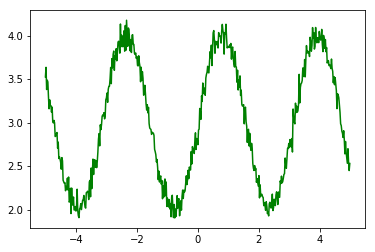

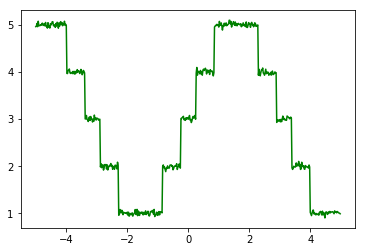

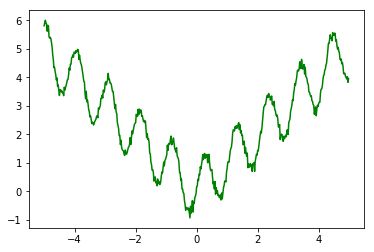

In [71]:
# dataset

def f_sin(x): return sin(2*x) + 3

def f_round(x): return round(2*sin(x) + 3)

def f_absin(x): return sin(6*x) + abs(x)


x = np.arange(-5, 5, 0.02).reshape(-1,1)
y_f1 = np.array([f_sin(x) + np.random.normal(0, 0.08) for x in x]).reshape(-1,1)
y_f2 = np.array([f_round(x) + np.random.normal(0, 0.04) for x in x]).reshape(-1,1)
y_f3 = np.array([f_absin(x) + np.random.normal(0, 0.1) for x in x]).reshape(-1,1)


plt.plot(x,y_f1, 'green')
plt.show()

plt.plot(x,y_f2, 'green')
plt.show()

plt.plot(x,y_f3, 'green')
plt.show()


### Section 1.3: Variables Globales

In [72]:
epochs = 30000
batch_size = 100

x_batch = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='x_batch')
y_batch = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='y_batch')

### Section 1.4: Fit

In [73]:
def Fit(x_train,y_train,model, verbose = 2000):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    for epoch in range(epochs):
        indices = np.random.choice(x_train.shape[0], size=batch_size)
        x_b = x_train[indices]
        y_b = y_train[indices]
        feed_dict = {x_batch: x_b, y_batch: y_b}
        sess.run(model, feed_dict=feed_dict)
        if epoch%verbose ==0:
            print("Loss = ", sess.run(avg_llh, feed_dict=feed_dict))
    return sess

### Section 1.5: Predict

In [74]:
def Predict(x_test,session):
    x_b = np.hstack([x_test.reshape((-1,1))])
    feed_dict = {x_batch: x_b}
    yh_vals = session.run((y_pred), feed_dict=feed_dict)
    return yh_vals

    

### Section 1.6: MLP

In [75]:
def MLP(x_b,tab_neurones, tab_activation):
    outs = []
    for i in range(len(tab_neurones)):
        if i == 0 :
            input_nb_neurone = x_b.shape[1]
            input_data = x_b
        else:
            input_nb_neurone = tab_neurones[i-1]
            input_data = outs[i-1]
        A = tf.Variable(np.random.rand(input_nb_neurone,tab_neurones[i]), dtype=tf.float64)
        b = tf.Variable(np.random.rand(tab_neurones[i]), dtype=tf.float64)
        if (tab_activation[i] == "relu"):
            out = tf.nn.relu(tf.matmul(input_data, A) + b)
        elif (tab_activation[i] == "sigmoid"):
            out = tf.nn.sigmoid(tf.matmul(input_data, A) + b)
        elif (tab_activation[i] == "tanh"):
            out = tf.tanh(tf.matmul(input_data, A) + b)
        else:
            out = tf.matmul(input_data, A) + b
        outs.append(out)
    return outs
        

### Section 1.7: Test d'un modèle

In [76]:
mlp1 = MLP(x_batch,[8,8,1], ['tanh','tanh','identity'])

# output layer
y_pred = mlp1[-1]

# loss function
loglikelihoods = tf.square(y_pred - y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

In [77]:
# fit the model
modelFit = Fit(x,y_f1,model)

Loss =  5.698948001408792
Loss =  0.17747386794527487
Loss =  0.012793679318323377
Loss =  0.007855175427701937
Loss =  0.008785648230123257
Loss =  0.009501977515062621
Loss =  0.00896457636243017
Loss =  0.006519763459232188
Loss =  0.005889427260019517
Loss =  0.006023289168801332
Loss =  0.008638278631614644
Loss =  0.007737803661944008
Loss =  0.00723561713942592
Loss =  0.0060220488053974
Loss =  0.008121868081599357


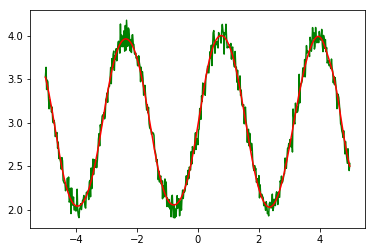

In [78]:
# predict 
modelPredict = Predict(x,modelFit)

plt.plot(x,y_f1, 'green')
plt.plot(x,modelPredict, 'red')
plt.show()

## Partie 2: Utilisation des différentes fonctions d'activation.

Dans cette partie, nous allons étudier les 4 fonctions d'activation (Relu, sigmoide, tanh, identité).
Pour ce faire, nous avons choisi un optimiseur (Adam) de manière à ne changer que la couche d'activation.

### Section 2.1: fonction de test

In [33]:
# mse

def mse(y_pred,y):
    return np.mean(np.square(y_pred - y))

npArray1 = np.array([1,2,4])
npArray2 = np.array([1,3,7])

print("mse = " + str(mse(npArray1,npArray2)))

# mae

def mae(y_pred,y):
    return np.mean(np.abs(y_pred - y))

print("mae = " + str(mae(npArray1,npArray2)))

mse = 3.3333333333333335
mae = 1.3333333333333333


In [29]:
# test with mean of n launch

def testFunctionActivation(n, x_vals, y_vals, model):
    liste_result = []
    for i in range(n):
        session = Fit(x_vals, y_vals, model, verbose = 10000)
        y_result = Predict(x_vals,session)
        liste_result.append(y_result)
        session.close()
    result = np.mean(liste_result, axis = 0)
    return result.reshape(result.shape[0],1)
        

### Section 2.2: Relu

In [30]:
# model with Relu

mlp_relu = MLP(x_batch,[8,8,8,1], ['relu','relu','relu','identity'])

# output layer
y_pred = mlp_relu[-1]

# loss function
loglikelihoods = tf.square(y_pred - y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelRelu = opt.minimize(avg_llh)

In [31]:
# train model
resRelu_sin = testFunctionActivation(10,x,y_f1,modelRelu)
resRelu_round = testFunctionActivation(10,x,y_f2,modelRelu)
resRelu_absin = testFunctionActivation(10,x,y_f3,modelRelu)

Loss =  10533.710030198139
Loss =  0.11016395996986987
Loss =  0.017050213405106457
Loss =  12504.720209676898
Loss =  0.14059724912552393
Loss =  0.018699489256521973
Loss =  16066.285399064527
Loss =  0.17386845590171218
Loss =  0.012931695853902647
Loss =  14439.694848788635
Loss =  0.2100348373012293
Loss =  0.01789567856043957
Loss =  6792.987031366045
Loss =  0.1924005495969564
Loss =  0.009343736294396096
Loss =  8301.224389739202
Loss =  0.16093435641843482
Loss =  0.011273854976788957
Loss =  17121.56319954788
Loss =  0.19996399200135584
Loss =  0.009561946511181139
Loss =  11468.774942604183
Loss =  0.1490503753040308
Loss =  0.009820719072469451
Loss =  10143.0509295796
Loss =  0.1629754497681708
Loss =  0.011339112734385657
Loss =  13951.642011141714
Loss =  0.1566315145771871
Loss =  0.008937004180345534
Loss =  11195.941145717065
Loss =  0.09085381025695691
Loss =  0.07152055235655456
Loss =  14255.275898852991
Loss =  0.07234934878712443
Loss =  0.05674515856415127
Loss 

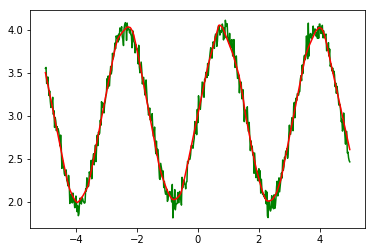

mae = 0.06499976675165822
mse = 0.006690816804926261


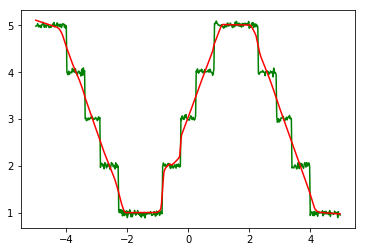

mae = 0.15979804051907676
mse = 0.049421085660731945


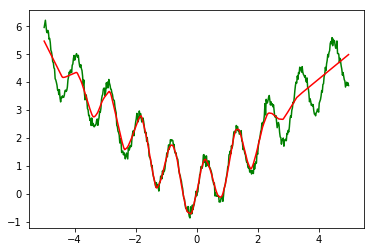

mae = 0.30560681665957296
mse = 0.17759839002746236


In [38]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resRelu_sin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_sin,y_f1)))
print( "mse = " + str(mse(resRelu_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resRelu_round, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_round,y_f2)))
print( "mse = " + str(mse(resRelu_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resRelu_absin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_absin,y_f3)))
print( "mse = " + str(mse(resRelu_absin,y_f3)))

### Section 2.3: Sigmoide

In [40]:
# model with sigmoid

mlp_sigmoid = MLP(x_batch,[8,8,8,1], ['sigmoid','sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_sigmoid[-1]


# loss function
loglikelihoods = tf.square(y_pred - y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelSigmoid = opt.minimize(avg_llh)

In [41]:
# train model
resSigmoid_sin = testFunctionActivation(10,x,y_f1,modelSigmoid)
resSigmoid_round = testFunctionActivation(10,x,y_f2,modelSigmoid)
resSigmoid_absin = testFunctionActivation(10,x,y_f3,modelSigmoid)

Loss =  0.5863246400780322
Loss =  0.19555563125747732
Loss =  0.165335862022784
Loss =  0.537024668289611
Loss =  0.264496498657113
Loss =  0.2797712689347133
Loss =  0.4967547266738588
Loss =  0.2656293968466074
Loss =  0.2542560849145527
Loss =  0.5583019936035609
Loss =  0.2031454259483175
Loss =  0.22102269579756764
Loss =  0.5779857123410541
Loss =  0.24358822105754271
Loss =  0.28226393856490684
Loss =  0.5832803817707963
Loss =  0.19571360417048594
Loss =  0.2392012995651104
Loss =  0.5710319414106785
Loss =  0.20323025002654105
Loss =  0.19880850397540922
Loss =  0.6480069305898093
Loss =  0.13668082223214295
Loss =  0.25005349954227585
Loss =  0.5906352561088543
Loss =  0.20957553457474654
Loss =  0.2853911187265279
Loss =  0.5820339328667045
Loss =  0.25069525687364086
Loss =  0.22157018587932614
Loss =  2.600801713705896
Loss =  0.0685433763031034
Loss =  0.06985381223833716
Loss =  2.3591424391878353
Loss =  0.054154734047544596
Loss =  0.0612731028007767
Loss =  2.7729743

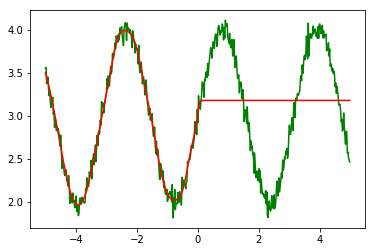

mae = 0.32079684505412687
mse = 0.22866462634151674


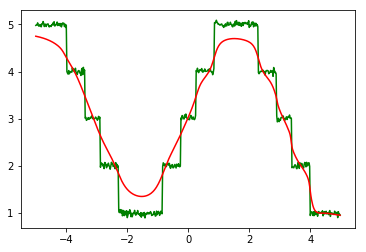

mae = 0.28745411254346015
mse = 0.11820217577039986


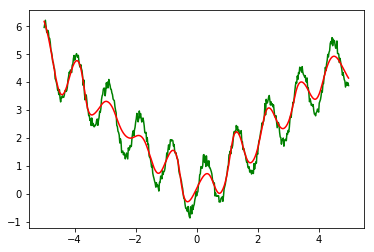

mae = 0.2664129877658117
mse = 0.10888137531367596


In [42]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resSigmoid_sin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_sin,y_f1)))
print( "mse = " + str(mse(resSigmoid_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resSigmoid_round, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_round,y_f2)))
print( "mse = " + str(mse(resSigmoid_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resSigmoid_absin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_absin,y_f3)))
print( "mse = " + str(mse(resSigmoid_absin,y_f3)))

### Section 2.4: Tanh

In [43]:
# model with tanh

mlp_tanh = MLP(x_batch,[8,8,8,1], ['tanh','tanh','tanh','identity'])

# output layer
y_pred = mlp_tanh[-1]


# loss function
loglikelihoods = tf.square(y_pred - y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelTanh = opt.minimize(avg_llh)

In [44]:
# train model
resTanh_sin = testFunctionActivation(10,x,y_f1,modelTanh)
resTanh_round = testFunctionActivation(10,x,y_f2,modelTanh)
resTanh_absin = testFunctionActivation(10,x,y_f3,modelTanh)

Loss =  18.52724373880445
Loss =  0.008118242517395213
Loss =  0.004940946527908446
Loss =  16.665759701139244
Loss =  0.006693952846026669
Loss =  0.006411202363727873
Loss =  17.339236498318122
Loss =  0.007284046382434183
Loss =  0.008658008818549239
Loss =  18.038736074456754
Loss =  0.011653705984492502
Loss =  0.007033090109690312
Loss =  16.226015695335846
Loss =  0.006418890943147264
Loss =  0.0068498067351103085
Loss =  21.20089274276249
Loss =  0.007776814081566735
Loss =  0.00799724988111945
Loss =  19.66755174195592
Loss =  0.00636675381511109
Loss =  0.005751700061771367
Loss =  20.80440574346059
Loss =  0.006718077993652184
Loss =  0.0056311577495853785
Loss =  16.32047246831916
Loss =  0.008562176522915039
Loss =  0.006041082302127982
Loss =  17.43698119891349
Loss =  0.00862127038813055
Loss =  0.007836893487051244
Loss =  19.749671023070192
Loss =  0.050078962500803605
Loss =  0.03599904328595972
Loss =  20.12888802989937
Loss =  0.041676535827354776
Loss =  0.02479646

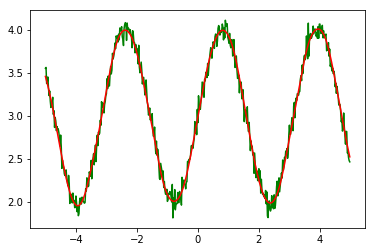

mae = 0.06179303510859712
mse = 0.005827074268139189


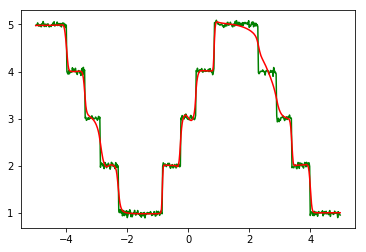

mae = 0.08536698523538233
mse = 0.01998364049634228


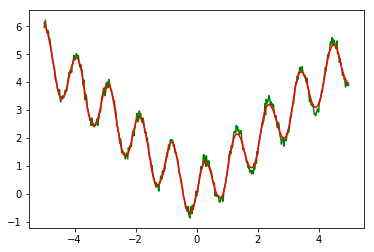

mae = 0.097237000630507
mse = 0.014720404192772705


In [46]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resTanh_sin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_sin,y_f1)))
print( "mse = " + str(mse(resTanh_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resTanh_round, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_round,y_f2)))
print( "mse = " + str(mse(resTanh_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resTanh_absin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_absin,y_f3)))
print( "mse = " + str(mse(resTanh_absin,y_f3)))

### Section 2.4: Identité

In [47]:
# model without activation

mlp_id = MLP(x_batch,[8,8,8,1], ['identity','identity','identity','identity'])

# output layer
y_pred = mlp_id[-1]


# loss function
loglikelihoods = tf.square(y_pred - y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelId = opt.minimize(avg_llh)

In [48]:
# train model
resId_sin = testFunctionActivation(10,x,y_f1,modelId)
resId_round = testFunctionActivation(10,x,y_f2,modelId)
resId_absin = testFunctionActivation(10,x,y_f3,modelId)

Loss =  9507.526296212882
Loss =  0.40472338618834647
Loss =  0.46174104882127376
Loss =  9944.645158005053
Loss =  0.46813607480371194
Loss =  0.4436534448594736
Loss =  12615.96282270906
Loss =  0.5009320312390025
Loss =  0.47085792304979385
Loss =  9024.24476117954
Loss =  0.49038121266486295
Loss =  0.5087106144122714
Loss =  9878.915525932514
Loss =  0.5370304395086365
Loss =  0.4189881819112054
Loss =  9445.459269029356
Loss =  0.5089856570154961
Loss =  0.49845599595860324
Loss =  8772.330097410573
Loss =  0.41847752003116767
Loss =  0.45714009710392667
Loss =  11591.335087305044
Loss =  0.4480256237315534
Loss =  0.5123960252723847
Loss =  10087.280878347483
Loss =  0.44911060336567493
Loss =  0.4836241084905367
Loss =  9636.158339292611
Loss =  0.4639497767852343
Loss =  0.5042308135066219
Loss =  10830.932891144084
Loss =  2.047438571305827
Loss =  2.1381573365343947
Loss =  9654.617960219059
Loss =  2.027971432716008
Loss =  2.3508790412066087
Loss =  9729.796207351865
Loss 

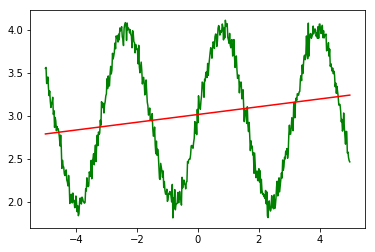

mae = 0.6038200249839625
mse = 0.470151047695818


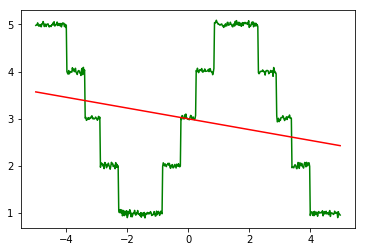

mae = 1.3196498171262352
mse = 2.2159401067840636


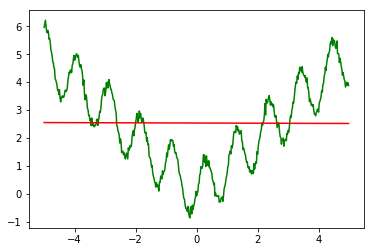

mae = 1.3571417926607805
mse = 2.621112649301699


In [49]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resId_sin, 'red')
plt.show()

print( "mae = " + str(mae(resId_sin,y_f1)))
print( "mse = " + str(mse(resId_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resId_round, 'red')
plt.show()

print( "mae = " + str(mae(resId_round,y_f2)))
print( "mse = " + str(mse(resId_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resId_absin, 'red')
plt.show()

print( "mae = " + str(mae(resId_absin,y_f3)))
print( "mse = " + str(mse(resId_absin,y_f3)))